<a href="https://colab.research.google.com/github/jihun0423/Baseball-pitcher-predict/blob/main/baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이번에 알아보고 싶은 것

야구에서 투수의 성적을 예측할 때에는, 여러가지 변수가 있다.
타자가 투수의 공을 얼마나 잘 치는가, 투수가 속한 팀의 수비 수준은 어떠한가,
투수가 투구하는 구장 환경은 어떠한가 등등 투수가 공을 던지는 능력과는 무관하다고 볼 수 있는 변수들이 매우 많다.

나는 여기서 수비와 운이라는 변수를 제외한 투수의 성적 예측하고자 한다. 따라서, 최대한 투수의 능력과 관련이 있는 변수들만을 사용해 예측을 할 예정이다.

이를테면, 투수가 던지는 공의 구속, 변화 정도, 스핀 수 등은 투수의 순수 능력이다.
다만, 위의 지표만 이용해서 분석을 할 경우, 구속이 빠른 투수가 예측 성적이 좋게 나올 확률이 높다. 따라서 제구력과 관련된 지표들을 여럿 넣었다. 

BABIP 이론에 따른다면, 타자가 배트에 공을 맞추었을때 나타나는 상황(아웃, 안타 등)은 어느 투수이던 간에 확률이 똑같다고 한다. 인플레이 타구의 결과는 투수와 수비수 모두의 책임이다. 따라서 인플레이 타구에 대해 투수의 책임이 있는 부분만을 다루는 스탯이 필요하며 이것이 바로 이번 예측에 사용할 지표인 xwoba 이다.



# 임포트

In [1]:
# encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler


from sklearn.preprocessing import MinMaxScaler

# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor

!pip install pycaret
from pycaret.regression import *

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

!pip install skorch

from skorch import NeuralNetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold
from sklearn import set_config

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00

In [2]:
! pip install pandasql   # 처음에만 실행

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=92a8c032fc6a5021146b09787186ef1eb1a12a716a6cf5112b768aceb321dabf
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [3]:
! pip install SQLAlchemy==1.4.46   # 처음에만 실행

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.10
    Uninstalling SQLAlchemy-2.0.10:
      Successfully uninstalled SQLAlchemy-2.0.10


# 데이터 출처

데이터는 BASEBALL-SAVANT라는 평소 매우 애용하고 있는 야구 통계 사이트에서 가져왔다. 자신이 원하는 컬럼만을 선택 할 수 있어, 전처리 과정이 편해진다는 장점이 있다.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd/content/gdrive/MyDrive

/content/gdrive/MyDrive


In [9]:
df=pd.read_csv("stats (7).csv")             # 모델 학습용 train 데이터. 2016~2022 시즌 투수들의 데이터

In [22]:
valid=pd.read_csv("stats (8).csv")          # 모델 검증용 valid 데이터. 2023 시즌 투수들의 데이터

* 최종 test 데이터는 train 데이터에서 2020~2022 3년간의 투수 스탯을 이용하여 
2023시즌의 투수 스탯을 짐작한 뒤, 모델을 이용해 예상 성적을 추출할 예정이다.
* valid 데이터에 있는 현재(2023.05.02) 까지의 성적은 이미 실제로 일어난 성적이므로 학습이나 test에는 사용하지 않고, 위에서 예상한 2023 성적과 비교하는 용도로 사용할 예정이다.

# 전처리

In [11]:
df.isnull().sum()

last_name                   0
 first_name                 0
player_id                   0
year                        0
p_k_percent                 0
p_bb_percent                0
xwoba                       0
z_swing_percent             0
z_swing_miss_percent        0
oz_swing_percent            0
oz_swing_miss_percent       0
oz_contact_percent          0
out_zone_percent            0
iz_contact_percent          0
in_zone_percent             0
edge_percent                0
whiff_percent               0
fastball_avg_speed          0
fastball_avg_spin           0
fastball_avg_break          0
breaking_avg_speed         35
breaking_avg_spin          36
breaking_avg_break         35
offspeed_avg_speed        567
offspeed_avg_spin         567
offspeed_avg_break        567
Unnamed: 26              4198
dtype: int64

결측치가 존재. 커브 같은 브레이킹볼이나, 체인지업류의 오프스피드 피치를 던지지 않는 투수들이 있어 생긴 결측치이다.

이 투수들은 저 구종들을 던지지 않으므로 구속, 회전수, 변화를 전부 0으로 둔 뒤,
브레이킹볼을 던지는지, 오프스피드를 던지는지 여부를 라벨 인코딩을 할 예정이다.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   last_name              4198 non-null   object 
 1    first_name            4198 non-null   object 
 2   player_id              4198 non-null   int64  
 3   year                   4198 non-null   int64  
 4   p_k_percent            4198 non-null   float64
 5   p_bb_percent           4198 non-null   float64
 6   xwoba                  4198 non-null   float64
 7   z_swing_percent        4198 non-null   float64
 8   z_swing_miss_percent   4198 non-null   float64
 9   oz_swing_percent       4198 non-null   float64
 10  oz_swing_miss_percent  4198 non-null   float64
 11  oz_contact_percent     4198 non-null   float64
 12  out_zone_percent       4198 non-null   float64
 13  iz_contact_percent     4198 non-null   float64
 14  in_zone_percent        4198 non-null   float64
 15  edge

# 컬럼 정보


*   last_name, first_name, player_id : 선수 이름, id
*   year : 년도
*   p_k_percent : 투수의 삼진율
*   p_bb_percent : 투수의 볼넷율
*   z_swing_percent : 스트라이크존 안에 던진 공의 스윙 유도율
*   z_swing_miss_percent : 스트라이크존 안에 던진 공의 헛스윙율
*   oz_swing_percent : 스트라이크존 밖에 던진 공의 스윙 유도율
*   oz_swing_miss_percent : 스트라이크존 밖에 던진 공의 헛스윙율
*   oz_contact_percent : 스트라이크존 밖에서 배트에 맞은 비율
*   out_zone_percent : 스트라이크존 밖으로 공을 던진 비율
*   iz_contact_percent : 스트라이크존 안에서 배트에 맞은 비율
*   in_zone_percent : 스트라이크존 안으로 공을 던진 비율
*   edge_percent : 스트라이크존 모서리 (보더라인)으로 공을 던진 비율
*   whiff_percent : 헛스윙 유도율
*   fastball_avg_speed,fastball_avg_spin,fastball_avg_break : 투수가 던진 직구 계열 투구의 평균 구속, 회전수, 변화정도
*   breaking_avg_speed,breaking_avg_spin,breaking_avg_break : 투수가 던진 브레이킹볼 (커브, 슬라이더 등)의 평균 구속, 회전수, 변화정도
*   offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break : 투수가 던진 오프스피드 피치 (체인지업류)의 평균 구속, 회전수, 변화정도

 
*   xwoba : 구하고자 하는 타겟. 수비와 운에 무관하게 기대되는 투수의 성적. 낮을 수록 성적이 좋음






In [14]:
df.head(3)

,last_name,first_name,player_id,year,p_k_percent,p_bb_percent,xwoba,z_swing_percent,z_swing_miss_percent,oz_swing_percent,...,fastball_avg_speed,fastball_avg_spin,fastball_avg_break,breaking_avg_speed,breaking_avg_spin,breaking_avg_break,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break,Unnamed: 26
0,Perez,Oliver,424144,2020,19.4,8.3,0.274,62.3,10.6,23.8,...,89.9,2114,19.4,76.1,2195.0,10.3,NaN,NaN,NaN,NaN
1,Wainwright,Adam,425794,2020,20.6,5.7,0.324,62.9,15.2,30.2,...,87.6,2253,13.5,73.5,2791.0,22.0,81.8,1683.0,15.3,NaN
2,Greinke,Zack,425844,2020,24.5,3.3,0.299,59.7,17.0,26.3,...,88.1,2327,17.6,77.7,2425.0,12.2,86.2,1668.0,14.0,NaN


## 결측치 제거를 위한 피쳐 생성

In [18]:
df['throws_breaking'] = 1
df.loc[df['breaking_avg_speed'].isnull()==1,'throws_breaking'] =0             # 브레이킹볼을 던지는지 여부에 따른 인코딩

In [23]:
valid['throws_breaking'] = 1
valid.loc[valid['breaking_avg_spin'].isnull()==1,'throws_breaking'] =0   

In [20]:
df['throws_offspeed'] = 1
df.loc[df['offspeed_avg_spin'].isnull()==1,'throws_offspeed'] =0             # 오프스피드볼을 던지는지 여부에 따른 인코딩

In [24]:
valid['throws_offspeed'] = 1
valid.loc[valid['offspeed_avg_spin'].isnull()==1,'throws_offspeed'] =0 

## 결측치 제거

In [25]:
df = df.fillna(0) # 결측치들을 전부 0으로 변경.

In [26]:
valid = valid.fillna(0)

## 불필요한 컬럼 제거

In [27]:
df.columns

Index(['last_name', ' first_name', 'player_id', 'year', 'p_k_percent',
       'p_bb_percent', 'xwoba', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'out_zone_percent', 'iz_contact_percent', 'in_zone_percent',
       'edge_percent', 'whiff_percent', 'fastball_avg_speed',
       'fastball_avg_spin', 'fastball_avg_break', 'breaking_avg_speed',
       'breaking_avg_spin', 'breaking_avg_break', 'offspeed_avg_speed',
       'offspeed_avg_spin', 'offspeed_avg_break', 'Unnamed: 26',
       'throws_breaking', 'throws_offspeed'],
      dtype='object')

In [30]:
valid.columns

Index(['last_name', ' first_name', 'player_id', 'year', 'p_k_percent',
       'p_bb_percent', 'xwoba', 'z_swing_percent', 'z_swing_miss_percent',
       'oz_swing_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'out_zone_percent', 'iz_contact_percent', 'in_zone_percent',
       'edge_percent', 'whiff_percent', 'fastball_avg_speed',
       'fastball_avg_spin', 'fastball_avg_break', 'breaking_avg_speed',
       'breaking_avg_spin', 'breaking_avg_break', 'offspeed_avg_speed',
       'offspeed_avg_spin', 'offspeed_avg_break', 'throws_breaking',
       'throws_offspeed'],
      dtype='object')

In [29]:
df= df.drop(columns=['Unnamed: 26'])     
valid=valid.drop(columns=['Unnamed: 26'])
  # 불필요한 컬럼 제거

In [6]:
train.columns

Index(['last_name', ' first_name', 'player_id', 'year', 'xwoba',
       'oz_swing_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'out_zone_swing_miss', 'out_zone_swing', 'out_zone_percent', 'out_zone',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'fastball_avg_speed', 'fastball_avg_spin', 'fastball_avg_break',
       'breaking_avg_speed', 'breaking_avg_spin', 'breaking_avg_break',
       'offspeed_avg_speed', 'offspeed_avg_spin', 'offspeed_avg_break',
       'throws_breaking', 'throws_offspeed'],
      dtype='object')

In [8]:
train.drop(columns=['out_zone_swing','out_zone','out_zone_swing_miss','in_zone_swing','in_zone_swing_miss','in_zone','edge']).columns

Index(['last_name', ' first_name', 'player_id', 'year', 'xwoba',
       'oz_swing_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'out_zone_percent', 'iz_contact_percent', 'in_zone_percent',
       'edge_percent', 'whiff_percent', 'fastball_avg_speed',
       'fastball_avg_spin', 'fastball_avg_break', 'breaking_avg_speed',
       'breaking_avg_spin', 'breaking_avg_break', 'offspeed_avg_speed',
       'offspeed_avg_spin', 'offspeed_avg_break', 'throws_breaking',
       'throws_offspeed'],
      dtype='object')

## 데이터 타입 변경

In [31]:
df['year'] = df['year'].astype('category')
df['player_id'] = df['player_id'].astype('category')
df['throws_breaking'] = df['throws_breaking'].astype('category')
df['throws_offspeed'] = df['throws_offspeed'].astype('category')                    # 데이터들의 타입을 바꿔주었다.
valid['throws_breaking'] = valid['throws_breaking'].astype('category')
valid['throws_offspeed'] = valid['throws_offspeed'].astype('category')     

# EDA

In [37]:
df.describe()

,p_k_percent,p_bb_percent,xwoba,z_swing_percent,z_swing_miss_percent,oz_swing_percent,oz_swing_miss_percent,oz_contact_percent,out_zone_percent,iz_contact_percent,...,whiff_percent,fastball_avg_speed,fastball_avg_spin,fastball_avg_break,breaking_avg_speed,breaking_avg_spin,breaking_avg_break,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break
count,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,...,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000,4198.000000
mean,22.287018,9.117127,0.318882,67.130348,17.732253,27.879014,41.585779,57.782873,51.660267,81.706908,...,25.162339,92.780205,2241.670557,17.445545,81.471201,2388.248452,10.176036,73.797404,1499.286803,13.687828
std,6.225344,3.295309,0.042521,4.352528,4.777835,4.115655,9.401976,9.355995,3.583753,4.741825,...,5.493908,2.706958,157.973880,2.530657,8.338336,334.994443,4.422081,29.313563,646.367781,6.043042
min,4.000000,0.000000,0.154000,46.400000,2.700000,12.100000,14.300000,13.600000,38.900000,59.600000,...,9.600000,80.300000,1593.000000,5.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,6.800000,0.291000,64.400000,14.400000,25.300000,35.300000,51.700000,49.200000,78.800000,...,21.400000,91.200000,2135.000000,16.000000,79.700000,2238.250000,6.800000,82.000000,1454.000000,12.700000
50%,21.700000,8.700000,0.317000,67.300000,17.400000,27.800000,41.100000,58.200000,51.500000,82.000000,...,24.800000,92.900000,2243.000000,17.900000,82.400000,2399.000000,9.500000,85.000000,1680.000000,15.600000
75%,26.100000,11.000000,0.345000,70.000000,20.700000,30.500000,47.700000,64.000000,54.000000,85.000000,...,28.500000,94.600000,2352.000000,19.200000,84.875000,2567.000000,13.300000,87.200000,1877.750000,17.500000
max,53.000000,32.100000,0.551000,81.800000,40.000000,46.600000,86.400000,85.700000,69.700000,97.300000,...,51.800000,101.100000,2889.000000,25.300000,92.700000,3295.000000,23.600000,96.400000,2852.000000,26.600000


## 피처들의 분포

array([[<Axes: title={'center': 'p_k_percent'}>,
        <Axes: title={'center': 'p_bb_percent'}>,
        <Axes: title={'center': 'xwoba'}>,
        <Axes: title={'center': 'z_swing_percent'}>,
        <Axes: title={'center': 'z_swing_miss_percent'}>],
       [<Axes: title={'center': 'oz_swing_percent'}>,
        <Axes: title={'center': 'oz_swing_miss_percent'}>,
        <Axes: title={'center': 'oz_contact_percent'}>,
        <Axes: title={'center': 'out_zone_percent'}>,
        <Axes: title={'center': 'iz_contact_percent'}>],
       [<Axes: title={'center': 'in_zone_percent'}>,
        <Axes: title={'center': 'edge_percent'}>,
        <Axes: title={'center': 'whiff_percent'}>,
        <Axes: title={'center': 'fastball_avg_speed'}>,
        <Axes: title={'center': 'fastball_avg_spin'}>],
       [<Axes: title={'center': 'fastball_avg_break'}>,
        <Axes: title={'center': 'breaking_avg_speed'}>,
        <Axes: title={'center': 'breaking_avg_spin'}>,
        <Axes: title={'center': '

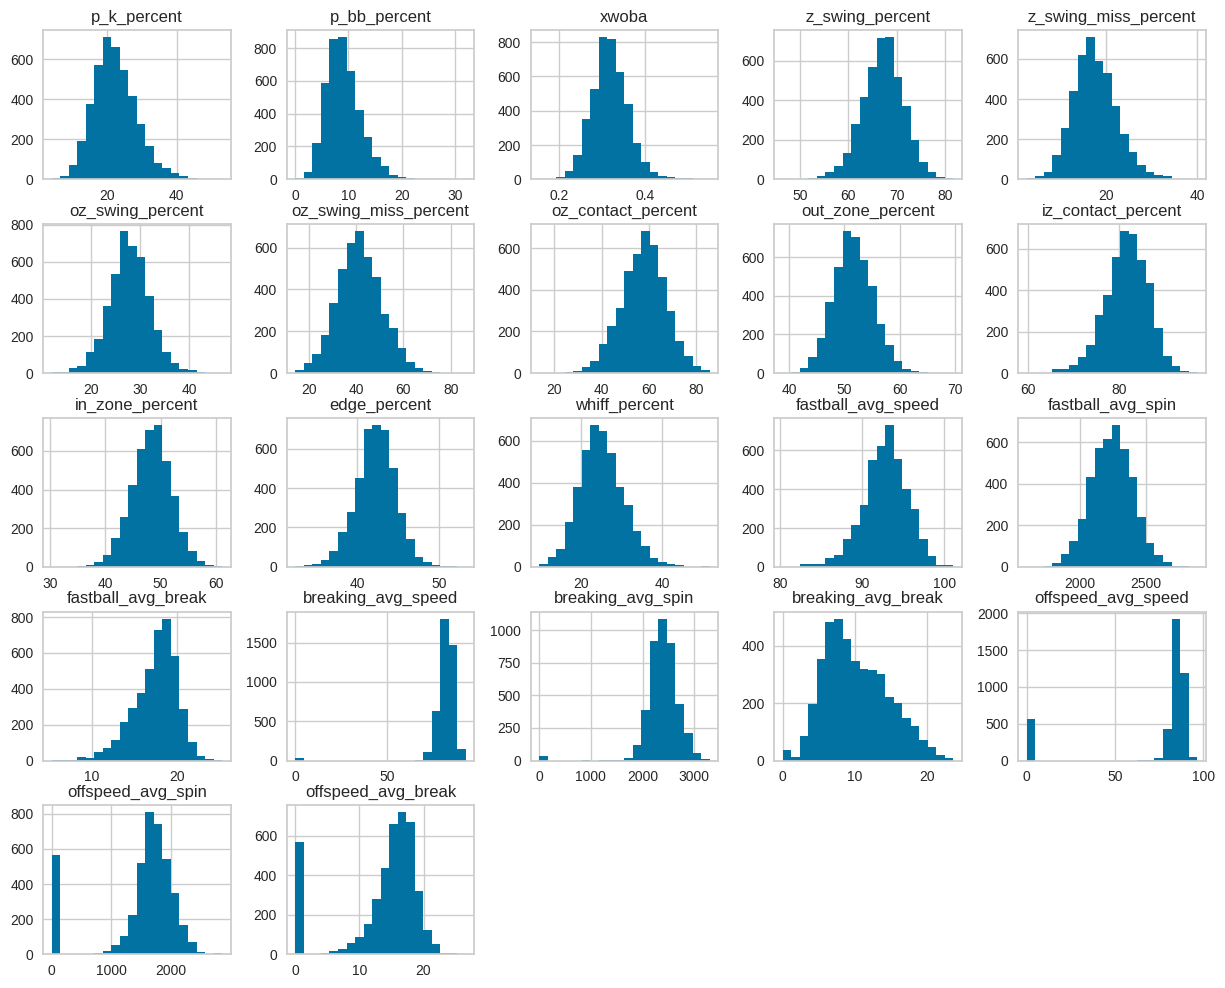

In [33]:
df.hist(bins=20,figsize=(15,12))

breaking ball과 offspeed와 관련된 피쳐들은 일부 0으로 대체하였고, 이들을 제외하고는 정규분포에 가까운 분포를 보인다.

## 투수가 던진 공과 성적간의 관계 시각화

In [54]:
pitch_features = ['fastball_avg_speed','fastball_avg_spin', 'fastball_avg_break', 'breaking_avg_speed','breaking_avg_spin', 'breaking_avg_break', 'offspeed_avg_speed','offspeed_avg_spin', 'offspeed_avg_break']
# 시각화를 위해 투수가 던진 공에 관련된 피쳐들만 추출하였다.

통상적인 생각으로는, 투수가 던지는 공의 구속이 빠를수록, 성적이 더 좋을 것이라고 예상한다. 공이 빠를수록 타자가 반응할 수 있는 시간이 짧아서, 그만큼 배트에 덜 맞을 확률이 높기 때문이다. 실제로 그런지 확인해보았다.

In [55]:
def regplot(col):
  fig = plt.subplots(figsize=(18,5))
  plt.title(f'{col} vs xwoba',fontsize=15)
  sns.regplot(x = col, y = 'xwoba', data = df[df[col]!=0])

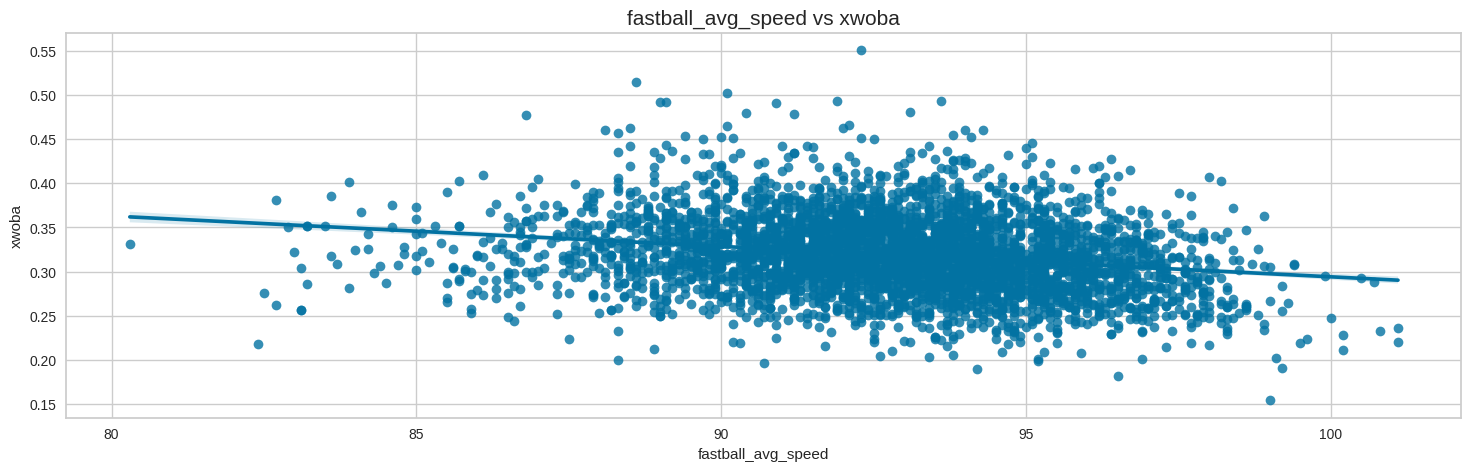

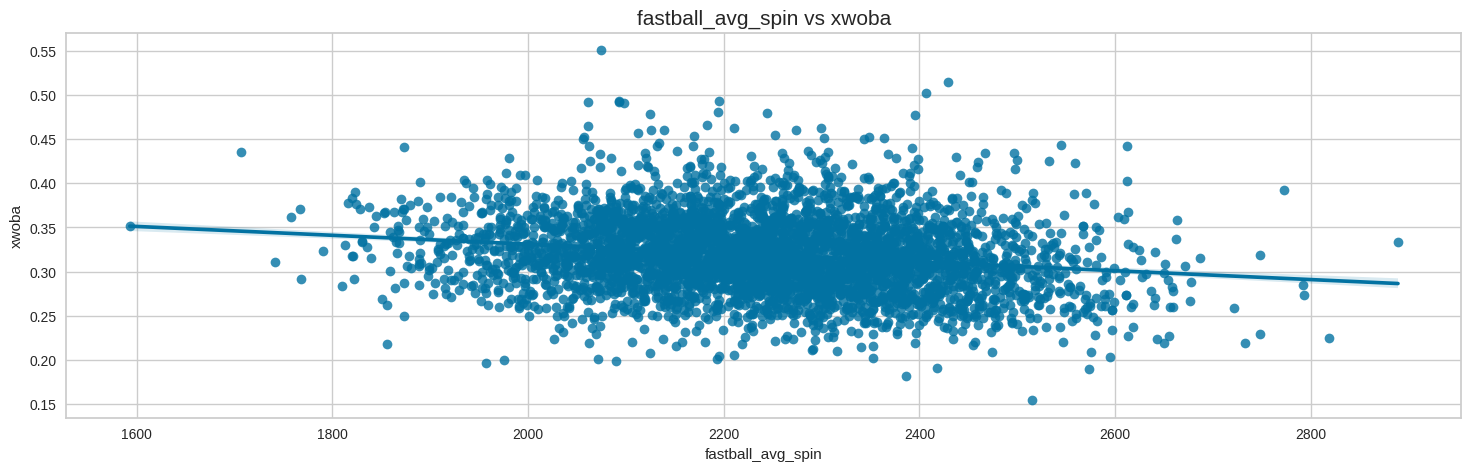

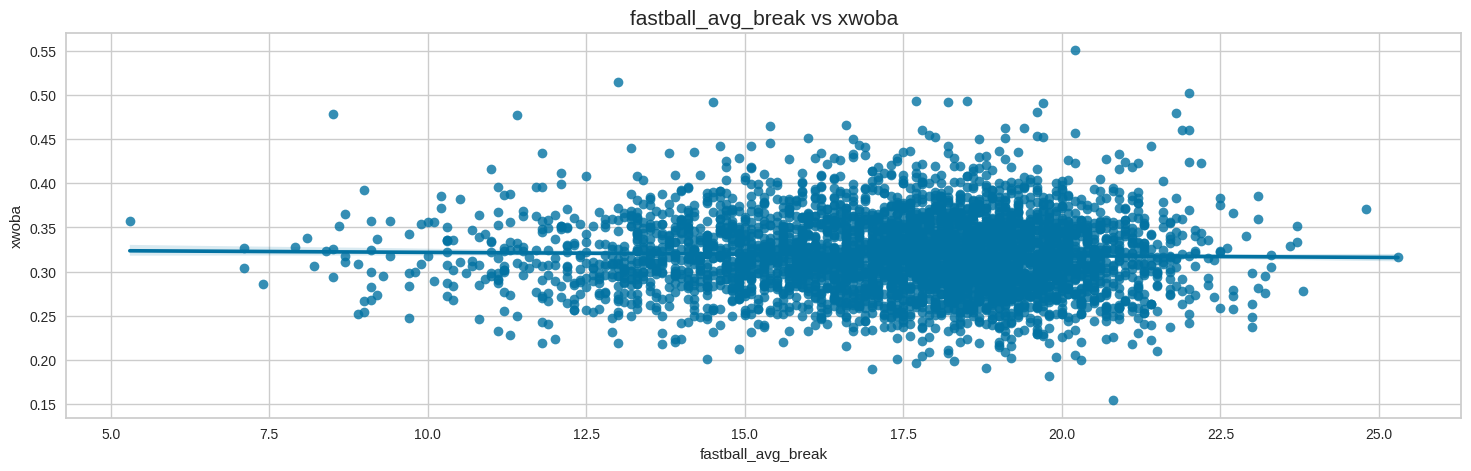

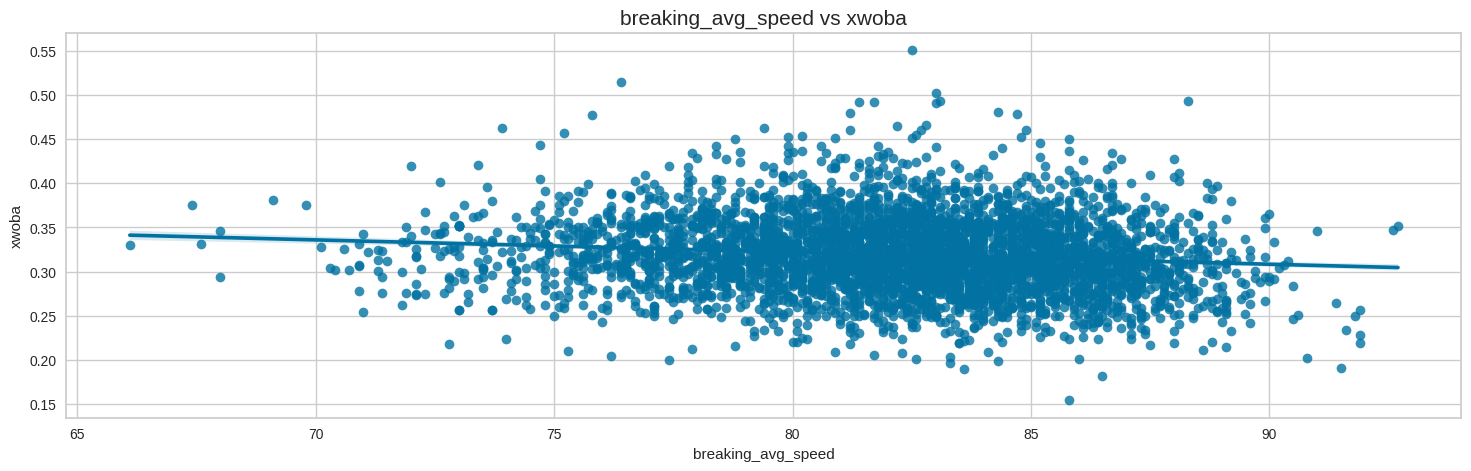

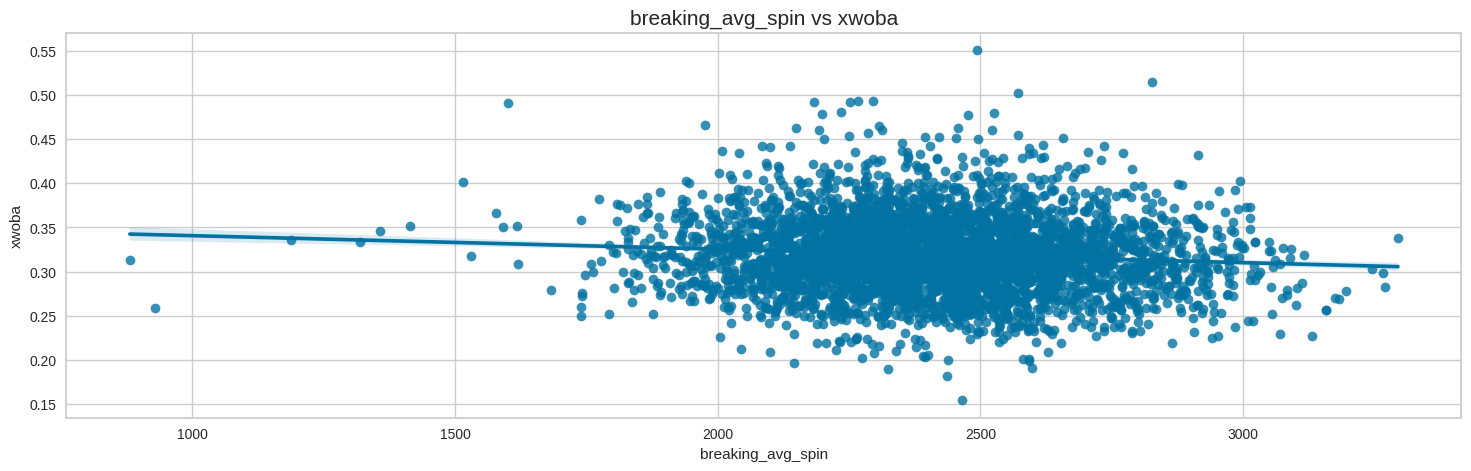

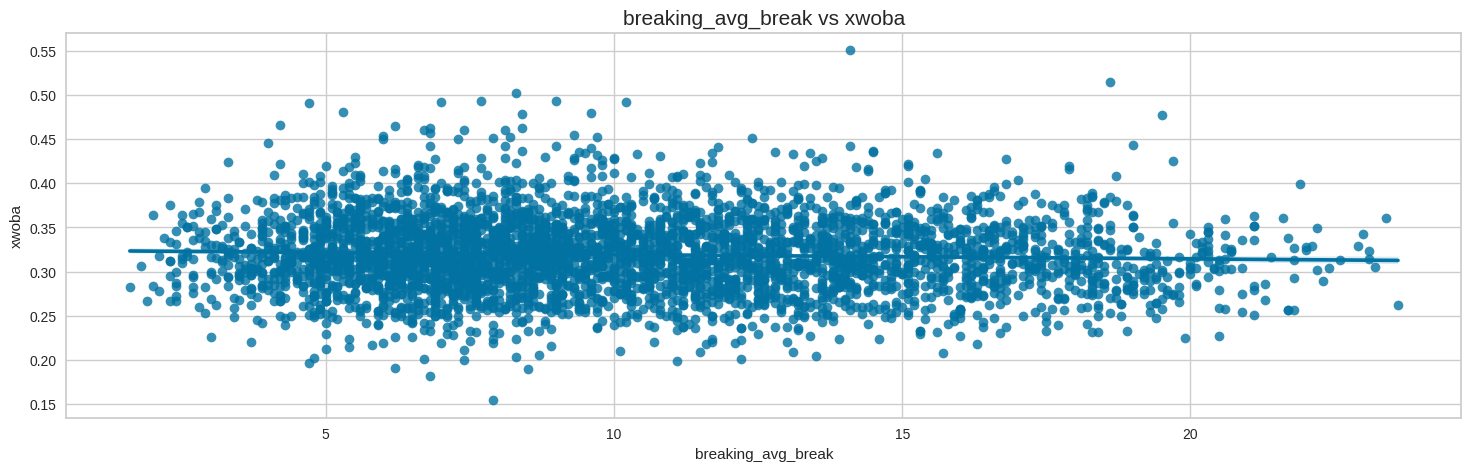

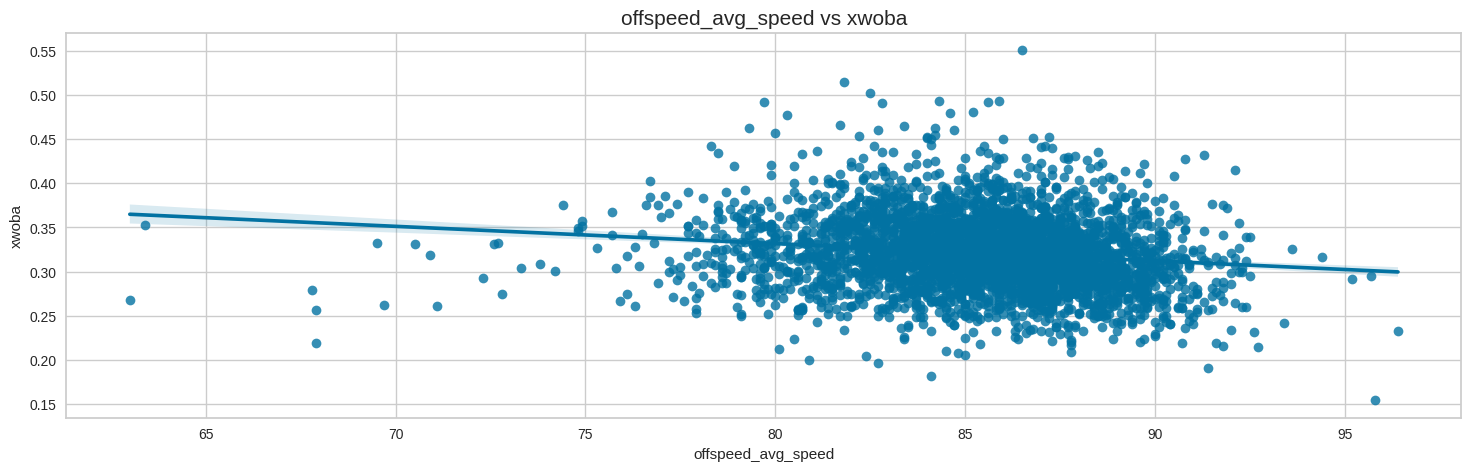

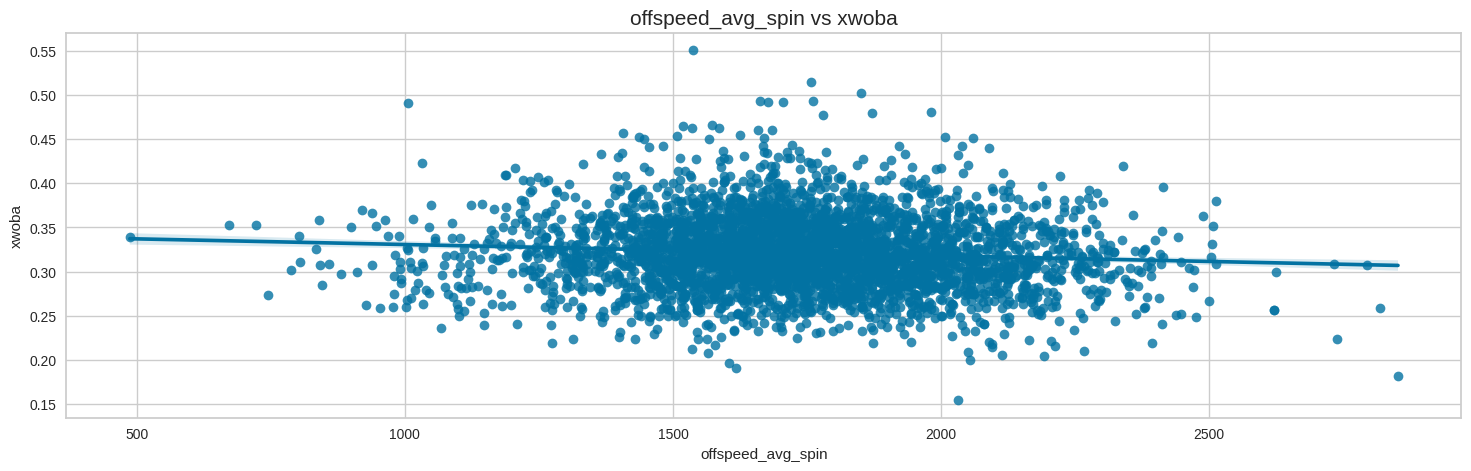

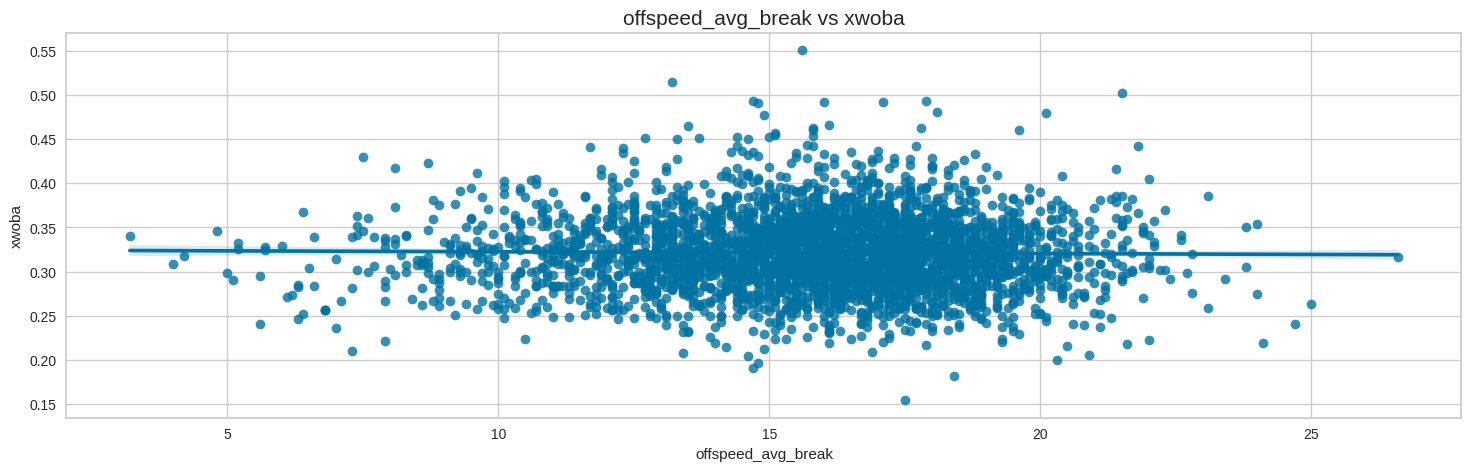

In [56]:
for col in pitch_features:
  regplot(col)

위의 그래프에서 알게 된 점
* 실제로 구속이 빠를수록 예상 성적은 줄어드는 것을 볼 수 있다.
* 구속뿐만 아니라, 회전수도 성적에 영향을 많이 미치는 것을 알 수 있다.
* 의외로 변화구들의 변화정도에 따른 영향은 미미하다. 

## 새로운 피처 생성

그러나 평소 궁금했던 점이 한가지 더 있어서 피쳐를 추가해 보고자 한다.
체인지업같이 타이밍을 빼았는 공을 오프스피드 피치라고 하는데, 브레이킹볼처럼 큰 변화를 통해서 헛스윙을 유도하는 것이 아닌, 직구와 비슷한 궤적으로 가지만 타자의 바로 앞에서 갑자기 궤도를 바꾸며 헛스윙을 유도하는 구종들이다. 이러한 오프스피드 피치의 핵심은 패스트볼과의 구속 차이이다. 어느정도의 구속 차이가 있어야 타자의 타이밍을 빼았는다고 들었는데, 그렇다면 구속 차이가 클 수록 좋은 것인지 궁금하여 피쳐를 생성해 그래프를 그려보기로 한다.

In [57]:
fastball_offspeed = df[df['throws_offspeed']==1]    # 오프스피드 피치를 던지는 선수들의 데이터만 불러온다.

In [58]:
fastball_offspeed['fastball-offspeed'] = fastball_offspeed['fastball_avg_speed'] - fastball_offspeed['offspeed_avg_speed']  # 직구와 오프스피드의 구속 차이 피쳐 생성

<Axes: xlabel='fastball-offspeed', ylabel='xwoba'>

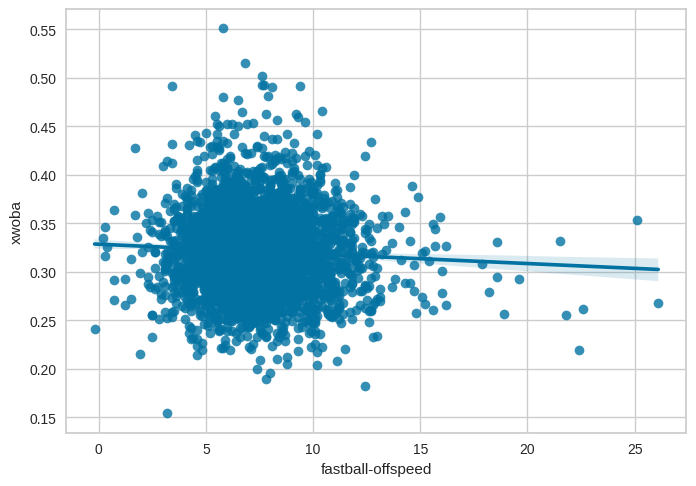

In [59]:
sns.regplot(x='fastball-offspeed',y='xwoba',data=fastball_offspeed)

직구와 오프스피드 피치의 구속 차이가 성적에 영향을 미친다는 것을 확인 할 수 있다. 이에 따라, 직구와 오프스피드 피치의 구속 차이 컬럼을 추가한다. 

In [60]:
df['fastball-offspeed'] = df['fastball_avg_speed'] - df['offspeed_avg_speed']
valid['fastball-offspeed'] = valid['fastball_avg_speed'] - valid['offspeed_avg_speed']

In [34]:
corr=df.corr()

In [ ]:
corr()              # 타겟인 xwoba와 피쳐들간의 상관관계가 꽤 있어보인다. 

,p_k_percent,p_bb_percent,xwoba,z_swing_percent,z_swing_miss_percent,oz_swing_percent,oz_swing_miss_percent,oz_contact_percent,out_zone_percent,iz_contact_percent,...,whiff_percent,fastball_avg_speed,fastball_avg_spin,fastball_avg_break,breaking_avg_speed,breaking_avg_spin,breaking_avg_break,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break
p_k_percent,1.000000,0.006547,-0.632168,-0.114872,0.717554,0.276470,0.643365,-0.640165,-0.035577,-0.714167,...,0.819420,0.385069,0.378272,0.134312,0.056508,0.100998,0.026827,-0.170138,-0.157589,-0.178235
p_bb_percent,0.006547,1.000000,0.259142,-0.195292,0.118003,-0.464047,0.160578,-0.159951,0.400130,-0.114701,...,0.161030,0.204411,0.103306,0.037033,0.065280,0.074445,-0.012164,-0.095794,-0.104767,-0.110434
xwoba,-0.632168,0.259142,1.000000,0.066484,-0.443716,-0.406967,-0.349537,0.348467,0.128879,0.449525,...,-0.497766,-0.219693,-0.186630,-0.022689,-0.009424,-0.034808,-0.037908,0.125287,0.096892,0.119213
z_swing_percent,-0.114872,-0.195292,0.066484,1.000000,0.152367,0.120069,-0.094261,0.096252,-0.111283,-0.145815,...,-0.019905,0.059521,0.066404,0.047325,0.011083,-0.178920,-0.275756,0.053130,0.034265,0.054353
z_swing_miss_percent,0.717554,0.118003,-0.443716,0.152367,1.000000,0.156250,0.390146,-0.384271,-0.055448,-0.991527,...,0.818379,0.336376,0.379454,0.189849,0.016833,0.013630,-0.061549,-0.102090,-0.078945,-0.086759
oz_swing_percent,0.276470,-0.464047,-0.406967,0.120069,0.156250,1.000000,0.150033,-0.149365,0.140485,-0.162908,...,0.319424,0.000641,0.068182,0.001727,0.003965,-0.042892,-0.126739,-0.004416,0.007032,-0.008901
oz_swing_miss_percent,0.643365,0.160578,-0.349537,-0.094261,0.390146,0.150033,1.000000,-0.995176,0.139626,-0.386082,...,0.805902,0.385959,0.271178,-0.009697,0.100478,0.108352,-0.095305,-0.171557,-0.181594,-0.215559
oz_contact_percent,-0.640165,-0.159951,0.348467,0.096252,-0.384271,-0.149365,-0.995176,1.000000,-0.140343,0.383389,...,-0.799849,-0.381718,-0.266075,0.012216,-0.096796,-0.105275,0.095612,0.167627,0.176945,0.211938
out_zone_percent,-0.035577,0.400130,0.128879,-0.111283,-0.055448,0.140485,0.139626,-0.140343,1.000000,0.049439,...,0.198348,-0.077471,-0.020717,-0.075169,-0.003405,0.020467,-0.067036,0.027646,0.020634,0.003863
iz_contact_percent,-0.714167,-0.114701,0.449525,-0.145815,-0.991527,-0.162908,-0.386082,0.383389,0.049439,1.000000,...,-0.813364,-0.324186,-0.365763,-0.185805,-0.013879,-0.010588,0.060409,0.098289,0.074862,0.082112


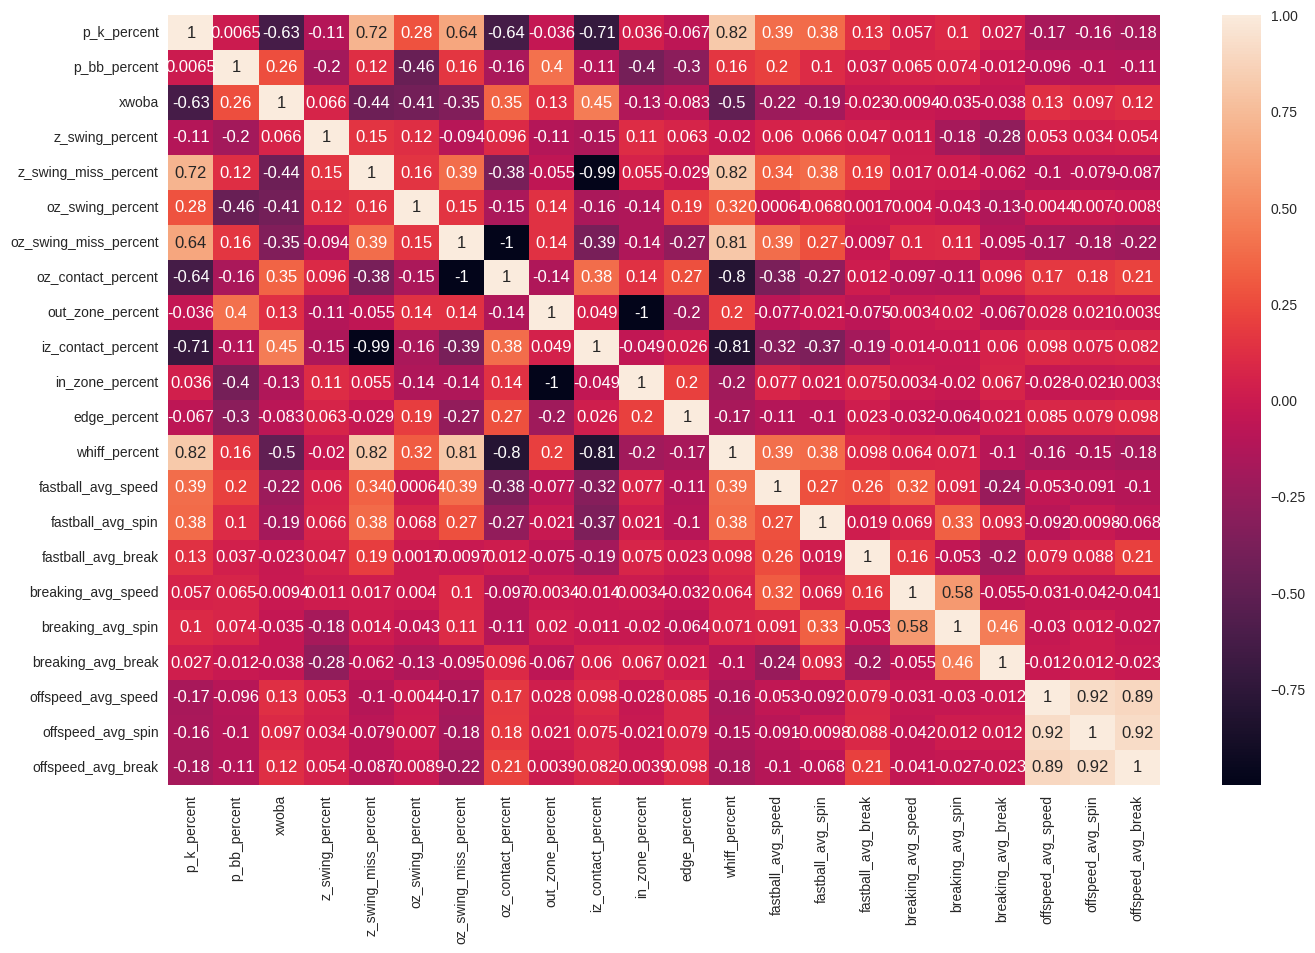

In [36]:
import seaborn as sns
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(),annot=True)
plt.show()

# MinMax Scaler

In [36]:
feature = df.drop(columns = ['last_name',' first_name','player_id','year','xwoba'])
target = df['xwoba']

In [40]:
scaler = MinMaxScaler()
feature = scaler.fit_transform(feature)

In [72]:
X_test = df.drop(columns = ['last_name',' first_name','player_id','year','xwoba'])
y_test = df['xwoba']

In [73]:
X_test = scaler.fit_transform(X_test)

# 데이터를 PICKLE 파일로 저장

CSV파일은 변수의 형식이 모두 초기화 되는 반면,
PKL파일은 변수의 형식도 그대로 남아 있기에 PKL로 저장하였다.

In [81]:
df.to_pickle('./'+'baseball_stat_train.pkl')

In [82]:
test.to_pickle('./'+'baseball_stat_test.pkl')

In [5]:
train = pd.read_pickle('baseball_stat_train.pkl')
test = pd.read_pickle('baseball_stat_test.pkl')

In [ ]:
train.head(3)

,last_name,first_name,player_id,year,xwoba,oz_swing_percent,oz_swing_miss_percent,oz_contact_percent,out_zone_swing_miss,out_zone_swing,...,fastball_avg_spin,fastball_avg_break,breaking_avg_speed,breaking_avg_spin,breaking_avg_break,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break,throws_breaking,throws_offspeed
0,Colon,Bartolo,112526,2016,0.318,30.2,22.4,75.9,91,406,...,2148,17.4,82.5,2282.0,7.9,81.4,1683.0,16.2,1,1
1,Grilli,Jason,276351,2016,0.305,28.4,49.1,50.3,80,163,...,2357,20.5,81.1,2605.0,13.9,84.9,2134.0,19.9,1,1
2,Benoit,Joaquin,276542,2016,0.294,34.7,40.9,57.3,67,164,...,2252,19.1,87.2,2422.0,6.8,84.5,1374.0,13.7,1,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   last_name              4198 non-null   object  
 1    first_name            4198 non-null   object  
 2   player_id              4198 non-null   category
 3   year                   4198 non-null   category
 4   xwoba                  4198 non-null   float64 
 5   oz_swing_percent       4198 non-null   float64 
 6   oz_swing_miss_percent  4198 non-null   float64 
 7   oz_contact_percent     4198 non-null   float64 
 8   out_zone_swing_miss    4198 non-null   int64   
 9   out_zone_swing         4198 non-null   int64   
 10  out_zone_percent       4198 non-null   float64 
 11  out_zone               4198 non-null   int64   
 12  iz_contact_percent     4198 non-null   float64 
 13  in_zone_swing_miss     4198 non-null   int64   
 14  in_zone_swing          4198 non-null   i

# AutoML

In [85]:
train = train.drop(columns = ['last_name',' first_name','player_id','year'] )

In [86]:
test_ = test.drop(columns = ['last_name',' first_name','player_id','year'])

## Model Train

In [88]:
setup_rgs = setup(data=train,target='xwoba')

,Description,Value
0,Session id,2732
1,Target,xwoba
2,Target type,Regression
3,Original data shape,"(4198, 27)"
4,Transformed data shape,"(4198, 27)"
5,Transformed train set shape,"(2938, 27)"
6,Transformed test set shape,"(1260, 27)"
7,Ordinal features,2
8,Numeric features,24
9,Categorical features,2


In [89]:
top5 = compare_models(sort='RMSE',n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0249,0.0011,0.0326,0.4085,0.0246,0.0791,0.6300
ridge,Ridge Regression,0.0249,0.0011,0.0326,0.4101,0.0245,0.0790,0.1400
br,Bayesian Ridge,0.0249,0.0011,0.0326,0.4110,0.0245,0.0790,0.1470
et,Extra Trees Regressor,0.0254,0.0011,0.0333,0.3844,0.0251,0.0810,1.9510
gbr,Gradient Boosting Regressor,0.0253,0.0011,0.0333,0.3855,0.0250,0.0804,1.6040
rf,Random Forest Regressor,0.0255,0.0011,0.0335,0.3773,0.0252,0.0813,4.4290
lightgbm,Light Gradient Boosting Machine,0.0256,0.0011,0.0338,0.3643,0.0255,0.0813,0.4920
ada,AdaBoost Regressor,0.0271,0.0012,0.0350,0.3166,0.0265,0.0877,0.6550
xgboost,Extreme Gradient Boosting,0.0268,0.0013,0.0353,0.3045,0.0266,0.0854,1.2670
en,Elastic Net,0.0318,0.0017,0.0411,0.0654,0.0310,0.1025,0.1410


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## GridSearch

In [90]:
tuned_top5 = [tune_model(i) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0244,0.0010,0.0321,0.4215,0.0242,0.0775
1,0.0253,0.0012,0.0339,0.4295,0.0253,0.0781
2,0.0235,0.0009,0.0304,0.4480,0.0231,0.0767
3,0.0248,0.0011,0.0329,0.3737,0.0248,0.0794
4,0.0256,0.0011,0.0331,0.4327,0.0250,0.0819
5,0.0262,0.0012,0.0351,0.3644,0.0264,0.0828
6,0.0252,0.0011,0.0328,0.4395,0.0246,0.0783
7,0.0259,0.0011,0.0337,0.4130,0.0254,0.0826
8,0.0255,0.0010,0.0314,0.3234,0.0238,0.0833


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0245,0.0010,0.0321,0.4221,0.0242,0.0775
1,0.0253,0.0012,0.0339,0.4299,0.0253,0.0781
2,0.0236,0.0009,0.0304,0.4478,0.0231,0.0767
3,0.0247,0.0011,0.0327,0.3787,0.0247,0.0791
4,0.0257,0.0011,0.0331,0.4327,0.0250,0.0820
5,0.0262,0.0012,0.0351,0.3649,0.0264,0.0828
6,0.0252,0.0011,0.0328,0.4396,0.0246,0.0783
7,0.0259,0.0011,0.0337,0.4132,0.0254,0.0826
8,0.0255,0.0010,0.0314,0.3237,0.0238,0.0833


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0245,0.0010,0.0320,0.4224,0.0242,0.0776
1,0.0254,0.0012,0.0339,0.4303,0.0253,0.0782
2,0.0236,0.0009,0.0305,0.4465,0.0232,0.0770
3,0.0246,0.0011,0.0325,0.3870,0.0245,0.0786
4,0.0258,0.0011,0.0332,0.4296,0.0250,0.0822
5,0.0262,0.0012,0.0351,0.3646,0.0264,0.0829
6,0.0252,0.0011,0.0329,0.4379,0.0246,0.0784
7,0.0258,0.0011,0.0337,0.4125,0.0254,0.0826
8,0.0254,0.0010,0.0314,0.3245,0.0238,0.0832


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0292,0.0014,0.0370,0.2310,0.0278,0.0914
1,0.0288,0.0015,0.0386,0.2610,0.0289,0.0898
2,0.0271,0.0012,0.0349,0.2744,0.0266,0.0895
3,0.0276,0.0013,0.0364,0.2328,0.0274,0.0877
4,0.0297,0.0015,0.0386,0.2300,0.0290,0.0942
5,0.0297,0.0015,0.0389,0.2193,0.0294,0.0949
6,0.0297,0.0014,0.0379,0.2523,0.0285,0.0934
7,0.0298,0.0015,0.0388,0.2196,0.0293,0.0967
8,0.0272,0.0012,0.0340,0.2078,0.0259,0.0899


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0259,0.0012,0.0346,0.3269,0.0260,0.0815
1,0.0261,0.0012,0.0348,0.4018,0.0260,0.0807
2,0.0241,0.0010,0.0318,0.3977,0.0241,0.0787
3,0.0251,0.0012,0.0344,0.3157,0.0259,0.0802
4,0.0271,0.0012,0.0353,0.3551,0.0266,0.0868
5,0.0279,0.0014,0.0374,0.2792,0.0282,0.0888
6,0.0267,0.0012,0.0344,0.3830,0.0258,0.0836
7,0.0276,0.0013,0.0362,0.3213,0.0273,0.0883
8,0.0258,0.0011,0.0329,0.2584,0.0250,0.0847


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [91]:
top5

[LinearRegression(n_jobs=-1),
 Ridge(random_state=2732),
 BayesianRidge(),
 ExtraTreesRegressor(n_jobs=-1, random_state=2732),
 GradientBoostingRegressor(random_state=2732)]

## 앙상블

In [92]:
blender_top5 = blend_models(estimator_list = tuned_top5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0243,0.0010,0.0321,0.4198,0.0242,0.0769
1,0.0253,0.0011,0.0336,0.4401,0.0251,0.0779
2,0.0232,0.0009,0.0299,0.4649,0.0228,0.0757
3,0.0243,0.0011,0.0324,0.3895,0.0245,0.0779
4,0.0257,0.0011,0.0330,0.4361,0.0249,0.0820
5,0.0261,0.0012,0.0349,0.3726,0.0263,0.0828
6,0.0253,0.0011,0.0328,0.4407,0.0245,0.0787
7,0.0258,0.0011,0.0338,0.4095,0.0255,0.0826
8,0.0249,0.0010,0.0309,0.3425,0.0235,0.0816


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## 최종 모델을 통한 예측

In [93]:
final_model = finalize_model(blender_top5)
prediction = predict_model(final_model, data=test_)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0372,0.0022,0.0464,0.2681,0.0351,0.1199


In [95]:
prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   oz_swing_percent       255 non-null    float32 
 1   oz_swing_miss_percent  255 non-null    float32 
 2   oz_contact_percent     255 non-null    float32 
 3   out_zone_swing_miss    255 non-null    int8    
 4   out_zone_swing         255 non-null    int8    
 5   out_zone_percent       255 non-null    float32 
 6   out_zone               255 non-null    int32   
 7   iz_contact_percent     255 non-null    float32 
 8   in_zone_swing_miss     255 non-null    int8    
 9   in_zone_swing          255 non-null    int32   
 10  in_zone_percent        255 non-null    float32 
 11  in_zone                255 non-null    int32   
 12  edge_percent           255 non-null    float32 
 13  edge                   255 non-null    int32   
 14  whiff_percent          255 non-null    flo

In [96]:
prediction['prediction_label']

0      0.342892
1      0.323907
2      0.342159
3      0.326377
4      0.317184
         ...   
250    0.352746
251    0.311420
252    0.305954
253    0.320448
254    0.331205
Name: prediction_label, Length: 255, dtype: float64

In [110]:
prediction['xwoba']

0      0.369
1      0.350
2      0.391
3      0.362
4      0.318
       ...  
250    0.389
251    0.273
252    0.383
253    0.298
254    0.344
Name: xwoba, Length: 255, dtype: float32

In [99]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(prediction['xwoba'], prediction['prediction_label'])**0.5
RMSE

0.04639949013558627

In [108]:
player2023 = test[['last_name',' first_name','player_id','xwoba']]

In [111]:
player2023['predicted'] = prediction['prediction_label']

In [112]:
player2023.head(10)

,last_name,first_name,player_id,xwoba,predicted
0,Greinke,Zack,425844,0.369,0.342892
1,Kluber,Corey,446372,0.350,0.323907
2,Hill,Rich,448179,0.391,0.342159
3,Morton,Charlie,450203,0.362,0.326377
4,Scherzer,Max,453286,0.318,0.317184
5,Lynn,Lance,458681,0.367,0.307684
6,Carrasco,Carlos,471911,0.411,0.373870
7,Garcia,Luis,472610,0.311,0.308765
8,Kershaw,Clayton,477132,0.265,0.279061
9,Miley,Wade,489119,0.320,0.342447


이대로 끝내기는 아쉬워서 수비와 운을 배제한 평균자책점인 xERA도 구해보았다.
xERA는 ERA와 마찬가지로 낮을 수록 좋으며, 만약 어떤 투수의 ERA가 xERA보다도 높다면, 운이 없었다거나 팀의 수비가 안좋다는 뜻으로 해석될 수 있다.

In [ ]:
# xERA = lg ERA × (wOBA / lg wOBA)^2                # lg ERA 는 리그 평균 평균자책점. 2023년의 경우 4.35이다.
                                                    

In [115]:
lgwOBA = player2023['predicted'].mean()

In [122]:
player2023['xERA'] = 4.35 * (player2023['predicted'] / lgwOBA ) **2

In [129]:
pd.set_option('display.max_rows', None) ## 모든 열을 출력한다.

In [130]:
player2023.sort_values('xERA')

,last_name,first_name,player_id,xwoba,predicted,xERA
235,Strider,Spencer,675911,0.244,0.232207,2.273715
224,Bednar,David,670280,0.166,0.234082,2.310581
171,McClanahan,Shane,663556,0.263,0.237208,2.372705
55,deGrom,Jacob,594798,0.214,0.251188,2.660616
126,Bautista,Felix,642585,0.236,0.253004,2.699215
65,Romano,Jordan,605447,0.220,0.254301,2.726963
159,Ryan,Joe,657746,0.250,0.266140,2.986784
109,Lopez,Pablo,641154,0.284,0.269090,3.053372
67,Springs,Jeffrey,605488,0.201,0.269836,3.070312
53,German,Domingo,593334,0.349,0.274662,3.181134
